# Inspiration

Hamel just announced that [fastpages will be discontinued](https://forums.fast.ai/t/fastpages-deprecating-fastpages-in-favor-of-quarto/99095) as nbdev+quarto is now a valid option to provide a blogging platform.
He has written a [migration guide](https://nbdev.fast.ai/tutorials/blogging.html) for that. 

This is my walkthrough.


# Walkthrough

Main software needed are:
* [quarto](https://quarto.org/docs/websites/website-blog.html)
* python env with jupyter (can blog from `base`)

## install quarto

```bash
$ sudo apt install quarto
[sudo] password for guillaume:
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
quarto is already the newest version (1.1.189).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
```

will have to see what will happen on platforms where I don't have admin rights.

Here Quarto is already present because I use it for nbdev2.


## create repo `blog`

I create `blog` repo on github.

And I can now get it locally: `git clone https://github.com/castorfou/blog.git` (I am from office, only https is accepted)

## create a quarto blog

```bash
cd ~/git/blog
quarto create-project --type website:blog .
quarto install extension quarto-ext/video
```

Issue here with `quarto install` when running from a corporate pc

```bash
$ quarto install extension quarto-ext/video
Sending fatal alert BadCertificate
ERROR: TypeError: error sending request for url (https://github.com/quarto-ext/video/archive/refs/heads/main.tar.gz): error trying to connect: invalid peer certificate contents: invalid peer certificate: UnknownIssuer
```

I have opened an issue at https://github.com/quarto-ext/video/issues/27

## copy former blog content - notebooks and markdown files

Your new repo will have a `posts/` directory. 

This is where you will copy all of your notebook and markdown posts from fastpages. 

```bash
cp -r ../guillaume_blog/_notebooks/* posts/
cp -r ../guillaume_blog/_posts/* posts/
```

I have to fix some stuff here, 

some markdown posts have empty description which is not allowed by the migration process.

To fix that I will run `sed -i -- 's/^description:[[:space:]*]$/description:\ \"\"/' ~/git/blog/posts/*.md`

Globally to identify culprit, I executed this:
```bash
chemin=`pwd`
for FILE in ../guillaume_blog/_posts/*; \
do echo $FILE; \
cp "$FILE" posts/; \
sed -i -- 's/^description:[[:space:]*]$/description:\ \"\"/' $chemin/posts/*.md; \
nbdev_migrate --path posts; \
rm -f posts/* 2> /dev/null; \
done;
```

but now that I know the migration issues, I can just execute:

```bash
# handle empty description in markdown files
chemin=`pwd`
sed -i -- 's/^description:[[:space:]*]$/description:\ \"\"/' $chemin/posts/*.md
# code should not be here
rm posts/notebook2script.py 
rm -rf posts/exp
```

What was wrong with `2021-02-10-college-de-france-representations-parcimonieuses.md` was accents in title. Removing é with e fixed it.

## copy former blog content - images

```bash
mkdir images
cp -r ../guillaume_blog/images/* images
cp -r ../guillaume_blog/images/copied_from_nb/* images
```

## migrate posts to quarto

```bash
conda activate dataset_tools #this is an env with nbdev installed
#install last version of nbdev
pip install -U nbdev
nbdev_migrate --path posts
```

## update some files

- `.gitignore`: we suggest adding `_site/` as well as dot files `.*`
- `about.qmd`: I reuse my former `_pages/about.md`
- `profile.jpg`: and use my profile picture

In [3]:
!cat ../.gitignore

/.quarto/
.*
!.gitignore
!.github


## preview

```bash
quarto preview
```

Here we can fix many thinks, and auto update rendered pages is just excellent!

* move images from posts to posts/images (have to restart quarto preview after that)
* delete the 2 examples (welcome and post-with-code)

Will have to browse through all the site to see if all is properly rendered. 
> fix for broken links or Jekyll shortcodes (things with {% ... %}) that need to be converted to Quarto. Search the the Quarto documentation if you need help locating specific Quarto features.



## keep git repo in sync

```bash
NOW=`date '+%F_%H:%M'`;
git add .
git commit -m "$NOW"
git push
```

## publication to gh-pages using gh-actions

There are 2 ways to publish. A straightforword one by calling `quarto publish`. And a more advanced one with github actions.

Using my corporate PC, `quarto publish` fails so I will give github actions a try.

### quarto publish

```bash
quarto publish gh-pages
```

:heavy_check_mark: This is ok when publishing with home PC. 

:x: But fails when publishing with corporate PC.see below [quarto publishing issue behind firewall](#quarto-publishing-issue-behind-firewall)

shared it with community at discord:
https://discord.com/channels/689892369998676007/1020178609605984267/1020631703653462038

### github actions

as explained in https://quarto.org/docs/publishing/github-pages.html#github-action


1st step is to decide where code is executed:
* local execution and rendering
* local execution with CI rendering
* CI execution and rendering

I think I will go for local execution and rendering.

#### freezing computations

To be added to `_quarto.yml`
```text
execute:
  freeze: auto
```

And then `quarto render`

#### publish actions

Add a publish.yml GitHub Action to your project by creating this YAML file and saving it to .github/workflows/publish.yml:

```text
on:
  workflow_dispatch:
  push:
    branches: main

name: Quarto Publish

jobs:
  build-deploy:
    runs-on: ubuntu-latest
    permissions:
      contents: write
    steps:
      - name: Check out repository
        uses: actions/checkout@v2

      - name: Set up Quarto
        uses: quarto-dev/quarto-actions/setup@v2

      - name: Render and Publish
        uses: quarto-dev/quarto-actions/publish@v2
        with:
          target: gh-pages
        env:
          GITHUB_TOKEN: ${{ secrets.GITHUB_TOKEN }}
```

We can now remove the publish command from `publish.sh`

And remove _site/ from `.gitignore` 



## open external links in new tabs

thanks to https://quarto.org/docs/reference/formats/html.html#links

In [16]:
!cat ../_quarto.yml |grep -A 2 external

    link-external-icon: true
    link-external-newwindow: true
    link-external-filter: ^(?:http:|https:)\/\/castorfou\.github\.io\/




## setup favicon.ico

Creation of a favicon for this blog. Using [gimp](https://www.gimp.org/tutorials/CircleImage/)
 
And quarto [doc for favicon](https://quarto.org/docs/websites/website-tools.html#favicon)



In [4]:
!cat ../_quarto.yml |grep -B 2 favico

website:
  title: "Guillaume's blog"
  favicon: favicon_small.png


And `favicon_small.png` is just at root.

In [5]:
!find ../  -name 'favicon_small.png'

../favicon_small.png
../_site/favicon_small.png


## (tbd) detect broken links

[Guillaume’s blog - Logbook for October 22](/posts/2022-10-01-logbook-October-22.html#week-42---october-22)

> And have to figure out a way to detect broken links:
> 
> -   using [google search console](https://search.google.com/u/0/search-console?resource_id=https%3A%2F%2Fcastorfou.github.io%2Fblog%2F)
> 
> As it takes a day to be processed I will test again tomorrow

## change theme and allow light/dark mode

In [13]:
!cat ../_quarto.yml | grep -A2 theme

    theme: 
      light: journal
      dark: darkly


And to have a light banner in the landing page

In [12]:
!cat ../index.qmd | grep banner

title-block-banner: false


## (tbd) fix latex expressions

## (tbd) google analytics on blog

[Guillaume’s blog - Logbook for October 22](/posts/2022-10-01-logbook-October-22.html#week-42---october-22)

> Setup [google analytics](https://support.google.com/analytics/answer/9539598?hl=en), get G- Id, and update `_quarto.yml` accordingly as explained in [quarto doc](https://quarto.org/docs/websites/website-tools.html#google-analytics).
> 
> Analytics available [here](https://analytics.google.com/analytics/web/?utm_source=marketingplatform.google.com&utm_medium=et&utm_campaign=marketingplatform.google.com%2Fabout%2Fanalytics%2F#/p338279857/reports/intelligenthome)

## (tbd) allow comments

# Publication process

In [1]:
!cat ../publish.sh

NOW=`date '+%F_%H:%M'`;
#quarto render
git add .
git commit -m "$NOW"
git push
#quarto publish gh-pages --no-prompt


# Issues / improvments

## [workaround] quarto publishing issue behind firewall

Identical to error happening when installing quarto extension

https://github.com/quarto-ext/video/issues/27


```bash
$ quarto publish
? Publish update to: › https://castorfou.github.io/blog/ (GitHub Pages)
From https://github.com/castorfou/blog
 * branch            gh-pages   -> FETCH_HEAD
 
origin  https://github.com/castorfou/blog.git (fetch)
origin  https://github.com/castorfou/blog.git (push)
To https://github.com/castorfou/blog.git
 + 0a3710d...1aeaf23 HEAD -> gh-pages (forced update)
fatal: 'fadc274b' is not a working tree

NOTE: GitHub Pages sites use caching so you might need to click the refresh
button within your web browser to see changes after deployment.

(\) Deploying gh-pages branch to website (this may take a few minutes)Sending fatal alert BadCertificate
[✓] Deploying gh-pages branch to website (this may take a few minutes)
ERROR: TypeError: error sending request for url (https://castorfou.github.io/blog/.nojekyll): error trying to connect: invalid peer certificate contents: invalid peer certificate: UnknownIssuer
```

For context, I use quarto as a replacement of fastai/fastpages and followed a migration guide from Hamel Hussain asking for this installation.

And I'm in a corporate environment with transparent proxies and self signed certificates. 
My system has updated CERT in /usr/local/share/ca-certificates/, and SSL_CERT_FILE environment variable pointing to updated corporate pem.

```
$ quarto install extension quarto-ext/lightbox
Sending fatal alert BadCertificate
ERROR: TypeError: error sending request for url (https://github.com/quarto-ext/lightbox/archive/refs/heads/main.tar.gz): error trying to connect: invalid peer certificate contents: invalid peer certificate: UnknownIssuer
```
It fails with the same message. 
When I run `quarto publish` I have the same issue.


One option is to use github actions as explained in [publication to gh-pages using gh-actions](/posts/2022-09-16-migrate%20blog%20from%20nbdev%20to%20quarto.html#publication-to-gh-pages-using-gh-actions). 

## [workaround] inline images are not properly rendered

analysis made at [inline images from jupyter with quarto](/posts/2022-09-23-inline-images-with-quarto.html)

short answer: use jupyter lab to blog

## Albert Rapp as an example

https://albert-rapp.de/posts/13_quarto_blog_writing_guide/13_quarto_blog_writing_guide.html

## [workaround] links are not rendered as links

in jupyter, just typing url turns it into a link. Not with quarto: https://castorfou.github.io/blog/

anyway to do it ?

[https://github.com/quarto-dev/quarto-cli/discussions/2609](https://github.com/quarto-dev/quarto-cli/discussions/2609)

### suggestions

First one is to surround url with pointy braces '<>'

Does it work: <https://pandoc.org/MANUAL.html#links-1>

And better one (?) would be to run pandoc with [autolink_bare_uris](https://pandoc.org/MANUAL.html#extension-autolink_bare_uris)


Just modifying `_quarto.yml` in ( format > html > from ) option

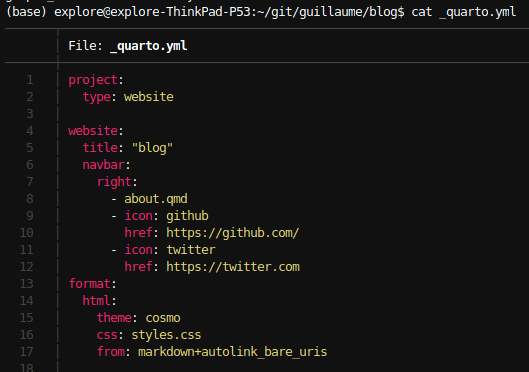

In [8]:
!cat ../_quarto.yml | grep -B5 autolink

  html:
    theme: 
      light: journal
      dark: darkly
    css: styles.css
    from: markdown+autolink_bare_uris


## quarto updated to version 1.2.269

```bash
~/temp$ wget https://github.com/quarto-dev/quarto-cli/releases/download/v1.2.269/quarto-1.2.269-linux-amd64.deb
~/temp$ sudo apt install ./quarto-1.2.269-linux-amd64.deb 
~/temp$ quarto -V
1.2.269
```

I don't know what is the changelog. Looks like we don't need to install video extension anymore. (quarto install extension quarto-ext/video)

```bash
~/git/blog$ quarto remove extension quarto-ext/video
```

I have started a [thread](https://forums.fast.ai/t/new-quarto-version-whats-new/102042) in fastai forum. There are updates with widget states and inline images. Update worth running!